# Compare NTTT vs SAM3 Metrics

This notebook loads saved prediction JSON files for NTTT and SAM3 models and computes COCO bounding box and segmentation metrics against ground-truth annotations.

It also includes custom IoU calculations and visualizations to compare model performance across different categories.

In [13]:
import json
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as mask_utils

# Set style for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## Configuration

Define paths to ground truth annotations and model predictions.

In [14]:
# Paths
GT_JSON_PATH = "/Users/mac/Developer/VScode/no-time-to-train/data/olive_diseases/annotations/instances_val2017.json"
WORK_DIR = "/Users/mac/Developer/VScode/no-time-to-train/work_dirs/olive_nttt_sam3_eval"

# Find prediction files
# Assuming the latest run or a specific run. 
# Adjust the glob pattern if you need a specific run.
def get_latest_predictions(pattern):
    files = glob(os.path.join(WORK_DIR, "*", pattern))
    if not files:
        raise FileNotFoundError(f"No files found matching {pattern} in {WORK_DIR}")
    # Return the most recent one based on modification time or just the first if ambiguous
    return sorted(files, key=os.path.getmtime)[-1]

nttt_pred_path = get_latest_predictions("nttt_predictions.json")
sam3_pred_path = get_latest_predictions("sam3_predictions.json")

print(f"Using NTTT Predictions: {nttt_pred_path}")
print(f"Using SAM3 Predictions: {sam3_pred_path}")

Using NTTT Predictions: /Users/mac/Developer/VScode/no-time-to-train/work_dirs/olive_nttt_sam3_eval/dinov3_small_5shot_seed42/nttt_predictions.json
Using SAM3 Predictions: /Users/mac/Developer/VScode/no-time-to-train/work_dirs/olive_nttt_sam3_eval/sam3_5shot_seed42/sam3_predictions.json


## 1. Load Data

Initialize COCO objects for Ground Truth and Predictions.

In [15]:
# Load Ground Truth
coco_gt = COCO(GT_JSON_PATH)

# Load Predictions
coco_nttt = coco_gt.loadRes(nttt_pred_path)
coco_sam3 = coco_gt.loadRes(sam3_pred_path)

# Get Categories
cats = coco_gt.loadCats(coco_gt.getCatIds())
cat_names = [cat['name'] for cat in cats]
cat_ids = [cat['id'] for cat in cats]
print(f"Categories: {cat_names}")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Categories: ['Anthracnose', 'BlackScale', 'OlivePeacockSpot', 'Psyllid', 'Tuberculosis']


## 2. Standard COCO Metrics (mAP)

Evaluate standard COCO metrics (AP, AP50, AP75) for bounding box and segmentation.

In [16]:
def evaluate_coco(coco_gt, coco_dt, iou_type="segm"):
    coco_eval = COCOeval(coco_gt, coco_dt, iou_type)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval

print("--- NTTT COCO Evaluation ---")
nttt_eval = evaluate_coco(coco_gt, coco_nttt, "segm")

print("\n--- SAM3 COCO Evaluation ---")
sam3_eval = evaluate_coco(coco_gt, coco_sam3, "segm")

--- NTTT COCO Evaluation ---
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.269
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.125
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.205
 Average Recall     (AR) @[ IoU=0.50:0.9

## 3. Custom IoU Metrics & Resizing Check

Calculate explicit IoU per mask to verify resizing correctness and provide granular stats.

In [17]:
def calculate_mask_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    if union == 0:
        return 0.0
    return intersection / union

def compute_per_image_iou(coco_gt, coco_dt, cat_ids):
    image_ids = coco_gt.getImgIds()
    results = []

    for img_id in image_ids:
        img_info = coco_gt.loadImgs(img_id)[0]
        h, w = img_info['height'], img_info['width']

        for cat_id in cat_ids:
            # Get GT anns
            ann_ids = coco_gt.getAnnIds(imgIds=img_id, catIds=cat_id)
            gt_anns = coco_gt.loadAnns(ann_ids)
            
            # Create GT mask (union of all instances of this class)
            gt_mask = np.zeros((h, w), dtype=np.uint8)
            for ann in gt_anns:
                if isinstance(ann['segmentation'], list):
                    rle = mask_utils.frPyObjects(ann['segmentation'], h, w)
                    m = mask_utils.decode(rle)
                else:
                    m = mask_utils.decode(ann['segmentation'])
                if len(m.shape) == 3:
                    m = m[:, :, 0]
                gt_mask = np.maximum(gt_mask, m)

            # Get DT anns
            dt_ann_ids = coco_dt.getAnnIds(imgIds=img_id, catIds=cat_id)
            dt_anns = coco_dt.loadAnns(dt_ann_ids)
            
            # Create DT mask (union prediction)
            dt_mask = np.zeros((h, w), dtype=np.uint8)
            for ann in dt_anns:
                # Handle RLE or Polygon
                if type(ann['segmentation']) == list:
                     rle = mask_utils.frPyObjects(ann['segmentation'], h, w)
                     m = mask_utils.decode(rle)
                elif type(ann['segmentation']) == dict:
                     m = mask_utils.decode(ann['segmentation'])
                
                # Check resizing: if mask shape doesn't match image shape
                if m.shape[:2] != (h, w):
                    print(f"Warning: Resizing mismatch! Pred: {m.shape}, Img: {(h, w)}")
                    # Resize to match
                    import cv2
                    m = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)
                
                if len(m.shape) == 3:
                    m = m[:, :, 0]
                dt_mask = np.maximum(dt_mask, m)

            # Compute IoU
            iou = calculate_mask_iou(gt_mask, dt_mask)
            
            # Only record if GT exists to avoid skewed metrics from empty-empty matches if desired
            # Or record 0 if GT exists but Pred doesn't. 
            if len(gt_anns) > 0:
                results.append({
                    'image_id': img_id,
                    'category_id': cat_id,
                    'iou': iou
                })

    return pd.DataFrame(results)

In [18]:
print("Computing Custom IoUs for NTTT...")
nttt_ious = compute_per_image_iou(coco_gt, coco_nttt, cat_ids)
nttt_ious['Model'] = 'NTTT'

print("Computing Custom IoUs for SAM3...")
sam3_ious = compute_per_image_iou(coco_gt, coco_sam3, cat_ids)
sam3_ious['Model'] = 'SAM3'

all_ious = pd.concat([nttt_ious, sam3_ious], ignore_index=True)

# Map category IDs to names
cat_id_to_name = {cat['id']: cat['name'] for cat in cats}
all_ious['Category'] = all_ious['category_id'].map(cat_id_to_name)

Computing Custom IoUs for NTTT...
Computing Custom IoUs for SAM3...


## 4. Visualizations & Comparison Tables

Compare the models graphically.

/var/folders/18/tt4qk8fx5kj_pq96nkcnfxzh0000gn/T/ipykernel_15839/1779759908.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=overall_miou, x='Model', y='iou', palette="viridis")


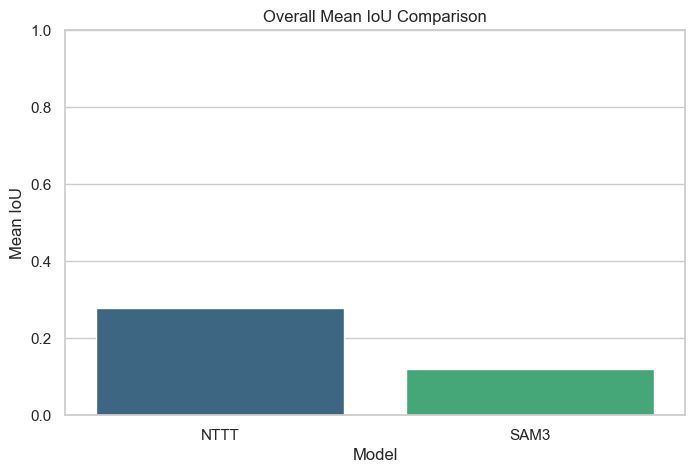

In [19]:
# 1. Overall Mean IoU Comparison
overall_miou = all_ious.groupby('Model')['iou'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=overall_miou, x='Model', y='iou', palette="viridis")
plt.title("Overall Mean IoU Comparison")
plt.ylabel("Mean IoU")
plt.ylim(0, 1)
plt.show()

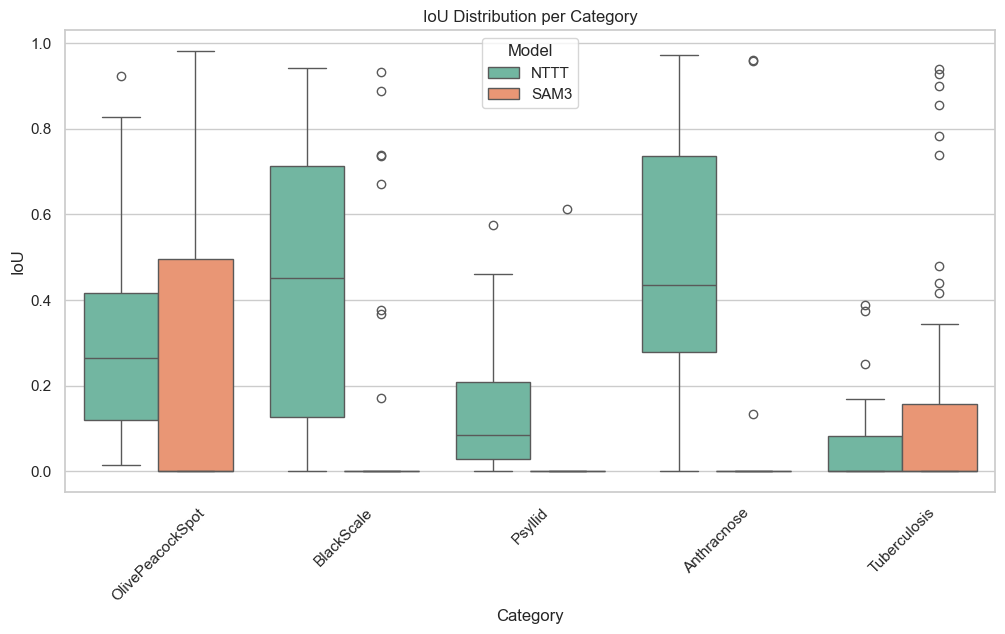

In [20]:
# 2. Per-Category IoU Comparison
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_ious, x='Category', y='iou', hue='Model', palette="Set2")
plt.title("IoU Distribution per Category")
plt.xticks(rotation=45)
plt.ylabel("IoU")
plt.show()

In [21]:
# 3. Comparison Table
pivot_table = all_ious.groupby(['Category', 'Model'])['iou'].mean().unstack()
pivot_table['Difference (SAM3 - NTTT)'] = pivot_table['SAM3'] - pivot_table['NTTT']
print("\n--- Per-Category Mean IoU ---")
display(pivot_table.style.background_gradient(cmap='coolwarm', subset=['Difference (SAM3 - NTTT)']))

print("\n--- Overall Summary ---")
summary = all_ious.groupby('Model')['iou'].agg(['mean', 'std', 'count'])
display(summary)


--- Per-Category Mean IoU ---


Model,NTTT,SAM3,Difference (SAM3 - NTTT)
Category,,,
Anthracnose,0.469008,0.053949,-0.415059
BlackScale,0.442388,0.108378,-0.334009
OlivePeacockSpot,0.325186,0.280940,-0.044246
Psyllid,0.138319,0.014573,-0.123746
Tuberculosis,0.051780,0.157485,0.105705



--- Overall Summary ---


,mean,std,count
Model,,,
NTTT,0.278395,0.290811,207
SAM3,0.120277,0.278325,207


## 5. Qualitative Visualization (Optional)

Visualize specific examples where one model outperforms the other significantly.

In [22]:
# Find 'Hard' examples (Low IoU for both) or Disagreement examples
merged = pd.merge(nttt_ious, sam3_ious, on=['image_id', 'category_id'], suffixes=('_nttt', '_sam3'))
merged['diff'] = merged['iou_sam3'] - merged['iou_nttt']

# Examples where SAM3 is much better
sam3_wins = merged.sort_values(by='diff', ascending=False).head(5)
# Examples where NTTT is much better
nttt_wins = merged.sort_values(by='diff', ascending=True).head(5)

print("Top 5 Frames where SAM3 >> NTTT:")
display(sam3_wins[['image_id', 'category_id', 'iou_nttt', 'iou_sam3', 'diff']])

print("Top 5 Frames where NTTT >> SAM3:")
display(nttt_wins[['image_id', 'category_id', 'iou_nttt', 'iou_sam3', 'diff']])

Top 5 Frames where SAM3 >> NTTT:


,image_id,category_id,iou_nttt,iou_sam3,diff
182,181,5,0.000000,0.926379,0.926379
62,61,5,0.000000,0.899663,0.899663
103,102,3,0.100293,0.978072,0.877779
21,21,5,0.000000,0.854133,0.854133
122,121,5,0.000000,0.783452,0.783452


Top 5 Frames where NTTT >> SAM3:


,image_id,category_id,iou_nttt,iou_sam3,diff
25,25,1,0.960536,0.0,-0.960536
131,130,1,0.932422,0.0,-0.932422
176,175,2,0.927002,0.0,-0.927002
85,84,2,0.923434,0.0,-0.923434
104,103,3,0.922771,0.0,-0.922771


## 6. Confusion Matrix (TP/FP/FN)

Extract detailed False Positive (FP), False Negative (FN), and True Positive (TP) counts for each category to understand the error modes.
- **TP**: Correctly predicted mask (IoU > 0.5)
- **FP**: Predicted mask with no matching ground truth (Phantom detection)
- **FN**: Ground truth mask with no matching prediction (Missed detection)

In [23]:
def get_confusion_matrix_data(coco_eval):
    """
    Extracts matches from COCOeval object for IoU=0.5 (index 0).
    Returns list of dicts with match details.
    """
    if not hasattr(coco_eval, 'evalImgs'):
        print("Please run coco_eval.evaluate() first.")
        return []

    p = coco_eval.params
    # We want IoU=0.5, which is usually at index 0
    # verify if 0.5 is at index 0
    if p.iouThrs[0] != 0.5:
        print(f"Warning: First IoU threshold is {p.iouThrs[0]}, expected 0.5")
    
    iou_idx = 0 
    area_idx = 0 # all areas
    
    matches = []
    
    # evalImgs is a flat list: len(catIds) * len(areaRng) * len(imgIds)
    # The order is: cat -> area -> img
    
    # We need to correctly map the flat index. 
    # Let's rely on the structure:
    # K = len(p.imgIds)
    # A = len(p.areaRng)
    # Index = c * A * K + a * K + i
    
    K = len(p.imgIds)
    A = len(p.areaRng)

    for c_idx, catId in enumerate(p.catIds):
        for i_idx, imgId in enumerate(p.imgIds):
            # Calculate linear index
            entry_idx = c_idx * A * K + area_idx * K + i_idx
            
            entry = coco_eval.evalImgs[entry_idx]
            
            # Entry might be None if no evaluation happened (e.g. no predictions and no GT for that category on that image?)
            # Actually COCOeval usually populates None if ignore constraints are met, 
            # but for standard eval it should be a dict if relevant.
            if entry is None:
                continue
                
            dt_ids = entry['dtIds']
            dt_m = entry['dtMatches'][iou_idx] # Array: for each dt, which gtId it matched (or 0)
            
            # We are interested in:
            # TP: dt matches a gt (dt_m[d] > 0)
            # FP: dt does not match gt (dt_m[d] == 0)
            # FN: gt not matched (we can infer this from gtMatches, or just count GTs - TPs)
            
            # Let's verify with gtMatches to be precise about WHICH gt was missed
            gt_ids = entry['gtIds']
            gt_m = entry['gtMatches'][iou_idx] # Array: for each gt, which dtId matched it (or 0)

            # Record TPs and FPs
            for d_idx, matched_gt_id in enumerate(dt_m):
                if matched_gt_id > 0:
                    matches.append({
                        'image_id': imgId,
                        'category_id': catId,
                        'type': 'TP',
                        'dt_id': dt_ids[d_idx], 
                        'gt_id': matched_gt_id
                    })
                else:
                    matches.append({
                        'image_id': imgId,
                        'category_id': catId,
                        'type': 'FP',
                        'dt_id': dt_ids[d_idx],
                        'gt_id': None
                    })
            
            # Record FNs
            for g_idx, matched_dt_id in enumerate(gt_m):
                if matched_dt_id == 0:
                     matches.append({
                        'image_id': imgId,
                        'category_id': catId,
                        'type': 'FN',
                        'dt_id': None,
                        'gt_id': gt_ids[g_idx]
                    })
    return matches

def display_confusion_matrix(coco_gt, coco_eval, name="Model"):
    match_data = get_confusion_matrix_data(coco_eval)
    if not match_data:
        print(f"No match data found for {name}")
        return

    df = pd.DataFrame(match_data)
    
    # Map category IDs to names
    cats = coco_gt.loadCats(coco_gt.getCatIds())
    cat_map = {c['id']: c['name'] for c in cats}
    df['category_name'] = df['category_id'].map(cat_map)
    
    # Group by category and type
    cm = df.groupby(['category_name', 'type']).size().unstack(fill_value=0)
    
    # Ensure TP, FP, FN columns exist
    for col in ['TP', 'FP', 'FN']:
        if col not in cm.columns:
            cm[col] = 0
            
    # Calculate Precision, Recall, F1
    cm['Precision'] = cm['TP'] / (cm['TP'] + cm['FP'])
    cm['Recall'] = cm['TP'] / (cm['TP'] + cm['FN'])
    cm['F1'] = 2 * (cm['Precision'] * cm['Recall']) / (cm['Precision'] + cm['Recall'])
    
    print(f"\n--- Confusion Matrix & Metrics for {name} ---")
    display(cm.style.background_gradient(cmap='Blues', subset=['TP', 'FP', 'FN'])
              .format("{:.2f}", subset=['Precision', 'Recall', 'F1']))
    
    return cm

print("Confusion Matrix helper functions defined.")

Confusion Matrix helper functions defined.


In [24]:
print("Generating Confusion Matrix for NTTT...")
cm_nttt = display_confusion_matrix(coco_gt, nttt_eval, "NTTT")

print("\nGenerating Confusion Matrix for SAM3...")
cm_sam3 = display_confusion_matrix(coco_gt, sam3_eval, "SAM3")

Generating Confusion Matrix for NTTT...

--- Confusion Matrix & Metrics for NTTT ---


type,FN,FP,TP,Precision,Recall,F1
category_name,,,,,,
Anthracnose,11,531,130,0.20,0.92,0.32
BlackScale,69,505,89,0.15,0.56,0.24
OlivePeacockSpot,16,2696,85,0.03,0.84,0.06
Psyllid,53,6281,68,0.01,0.56,0.02
Tuberculosis,198,2510,37,0.01,0.16,0.03



Generating Confusion Matrix for SAM3...

--- Confusion Matrix & Metrics for SAM3 ---


type,FN,FP,TP,Precision,Recall,F1
category_name,,,,,,
Anthracnose,138,23,3,0.12,0.02,0.04
BlackScale,154,29,4,0.12,0.03,0.04
OlivePeacockSpot,85,81,16,0.16,0.16,0.16
Psyllid,121,60,0,0.00,0.00,nan
Tuberculosis,227,68,8,0.11,0.03,0.05
